# パッケージインストール

In [ ]:
!pip install -q -U transformers==4.47.0
!pip install -q -U protobuf==4.25.2
!pip install -q -U sentencepiece
!pip install -q -U accelerate

# サンプル画像ダウンロード

In [ ]:
!wget https://raw.githubusercontent.com/Kazuhito00/Asagi-VLM-Colaboratory-Sample/refs/heads/main/sample.jpg -O sample.jpg

# モデル読み込み

In [3]:
# モデル選択
model_path = "sbintuitions/sarashina2-vision-8b"  # L4 GPU
# model_path = "sbintuitions/sarashina2-vision-14b"  # A100 GPU

In [ ]:
from transformers import AutoProcessor, AutoModelForCausalLM

processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="cuda",
    torch_dtype="auto",
    trust_remote_code=True,
)

# プロンプト生成

In [5]:
from PIL import Image

message = [
    {
        "role": "user",
        "content": "この写真に写っているもので、最も有名と考えられる建築物は何でどこに写っていますか？"
    }
]
text_prompt = processor.apply_chat_template(message, add_generation_prompt=True)

image = Image.open("sample.jpg").convert("RGB")
inputs = processor(
    text=[text_prompt],
    images=[image],
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")
stopping_criteria = processor.get_stopping_criteria(["\n###"])

# 推論

In [6]:
%%time

output_ids = model.generate(
    **inputs,
    max_new_tokens=128,
    temperature=0.0,
    do_sample=False,
    stopping_criteria=stopping_criteria,
)
generated_ids = [
    output_ids[len(input_ids) :] for input_ids, output_ids in zip(inputs.input_ids, output_ids)
]
output_text = processor.batch_decode(
    generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True
)

/usr/local/lib/python3.11/dist-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


CPU times: user 5.11 s, sys: 368 ms, total: 5.48 s
Wall time: 6.2 s


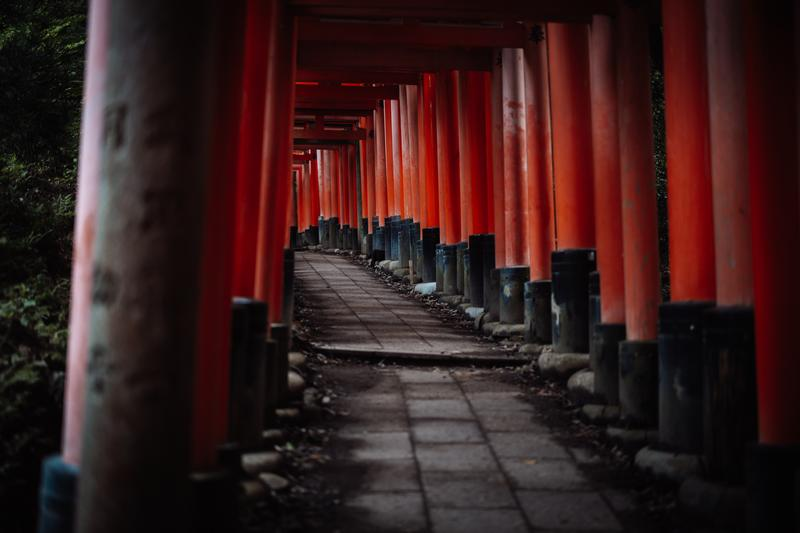

In [7]:
image

In [8]:
import textwrap

print(textwrap.fill(output_text[0], width=50))

 この写真に写っているもので、最も有名と考えられる建築物は鳥居です。鳥居は、日本の神社や寺院の入り口
に建てられる門のような構造物で、赤い色が特徴的です。この写真では、赤い鳥居が連なって立っている様子が
見られます。鳥居は、日本の文化や歴史において重要な役割を果たしており、国内外で広く知られています。
